In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip3 install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 10.2 MB/s eta 0:00:00


In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist

### Data Import

In [54]:
data = pd.read_csv("/content/drive/My Drive/spotify-dataset/data/data.csv")
genre_data = pd.read_csv('/content/drive/My Drive/spotify-dataset/data/data_by_genres.csv')

In [55]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()),
                                  ('kmeans', KMeans(n_clusters=20,
                                   verbose=False))
                                 ], verbose=False)

X = data.select_dtypes(np.number)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
data['cluster_label'] = song_cluster_labels

### Connect to Spotify API

In [8]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_id = "7d79fe83da984659b5581054295c34c9"
client_secret = "432302ce5805441dac55670e8a6144bd"
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [9]:
# API testing
name = ["Micheal Jackson","pitbull","Christina","Elvis Presley"]
result = sp.search(name)
result['tracks']['items'][2]['artists']

[{'external_urls': {'spotify': 'https://open.spotify.com/artist/3fMbdgg4jU18AjLCKBhRSm'},
  'href': 'https://api.spotify.com/v1/artists/3fMbdgg4jU18AjLCKBhRSm',
  'id': '3fMbdgg4jU18AjLCKBhRSm',
  'name': 'Michael Jackson',
  'type': 'artist',
  'uri': 'spotify:artist:3fMbdgg4jU18AjLCKBhRSm'}]

## Recommendation Based on Mean Vector & Cosine Similarity

In [10]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict


def find_song(name, year):
    song_data = defaultdict()
    results = sp.search(q= 'track: {} year: {}'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    song_data['name'] = [name]
    song_data['year'] = [year]
    song_data['explicit'] = [int(results['explicit'])]
    song_data['duration_ms'] = [results['duration_ms']]
    song_data['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_data[key] = value

    return pd.DataFrame(song_data)

In [11]:
from collections import defaultdict
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

number_cols = ['valence', 'year', 'acousticness', 'danceability', 'duration_ms', 'energy', 'explicit',
 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity', 'speechiness', 'tempo']


def get_song_data(song, spotify_data):

    try:
        song_data = spotify_data[(spotify_data['name'] == song['name'])
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_data

    except IndexError:
        return find_song(song['name'], song['year'])


def get_mean_vector(song_list, spotify_data):
    song_vectors = []

    for song in song_list:
        song_data = get_song_data(song, spotify_data)
        if song_data is None or not isinstance(song_data, pd.Series):
            print(f'Warning: {song["name"]} does not exist in Spotify or in database')
            continue

        song_vector = song_data[number_cols].values
        song_vectors.append(song_vector)

    if len(song_vectors) == 0:
        raise ValueError("No valid song data found. Cannot compute mean vector.")

    # Ensure all vectors have the same shape
    song_matrix = np.vstack(song_vectors)
    return np.mean(song_matrix, axis=0)


def flatten_dict_list(dict_list):

    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []

    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)

    return flattened_dict


def recommend_songs(song_list, spotify_data, n_songs=10):

    metadata_cols = ['name', 'year', 'artists']
    song_dict = flatten_dict_list(song_list)

    song_center = get_mean_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[number_cols])
    scaled_song_center = scaler.transform(song_center.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])

    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin(song_dict['name'])]
    return rec_songs[metadata_cols].to_dict(orient='records')

In [12]:
recommend_songs([{'name': 'Come As You Are', 'year':1991},
                {'name': 'Smells Like Teen Spirit', 'year': 1991},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993}
                 ],  data)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[{'name': 'Hanging By A Moment', 'year': 2000, 'artists': "['Lifehouse']"},
 {'name': 'Kiss Me', 'year': 1997, 'artists': "['Sixpence None The Richer']"},
 {'name': "Breakfast At Tiffany's",
  'year': 1995,
  'artists': "['Deep Blue Something']"},
 {'name': 'Otherside', 'year': 1999, 'artists': "['Red Hot Chili Peppers']"},
 {'name': "It's Not Living (If It's Not With You)",
  'year': 2018,
  'artists': "['The 1975']"},
 {'name': 'No Excuses', 'year': 1994, 'artists': "['Alice In Chains']"},
 {'name': 'Wherever You Will Go', 'year': 2001, 'artists': "['The Calling']"},
 {'name': 'Ballbreaker', 'year': 1995, 'artists': "['AC/DC']"},
 {'name': 'Runaway (U & I)', 'year': 2015, 'artists': "['Galantis']"},
 {'name': "Club Can't Handle Me (feat. David Guetta)",
  'year': 2010,
  'artists': "['Flo Rida', 'David Guetta']"}]

## K-means

In [46]:
# Load your data (replace with your file paths)
songs_df = pd.read_csv('/content/drive/My Drive/spotify-dataset/data/data.csv')

# Step 1: Feature Selection
selected_features = ['acousticness', 'danceability', 'energy', 'instrumentalness',
                     'liveness', 'loudness', 'speechiness', 'valence', 'tempo',
                     'duration_ms', 'key', 'mode']

# Step 2: Scaling the Features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(songs_df[selected_features])

# Step 3: PCA for Dimensionality Reduction
# Retain 95% of the variance
pca = PCA(n_components=0.95, random_state=42)
pca_features = pca.fit_transform(scaled_features)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Print explained variance ratio
print(f"Number of components selected: {pca.n_components_}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

Number of components selected: 10
Explained variance ratio: [0.25730985 0.12498319 0.09818916 0.09240748 0.08111295 0.07534458
 0.07188715 0.06907634 0.05765154 0.03206347]


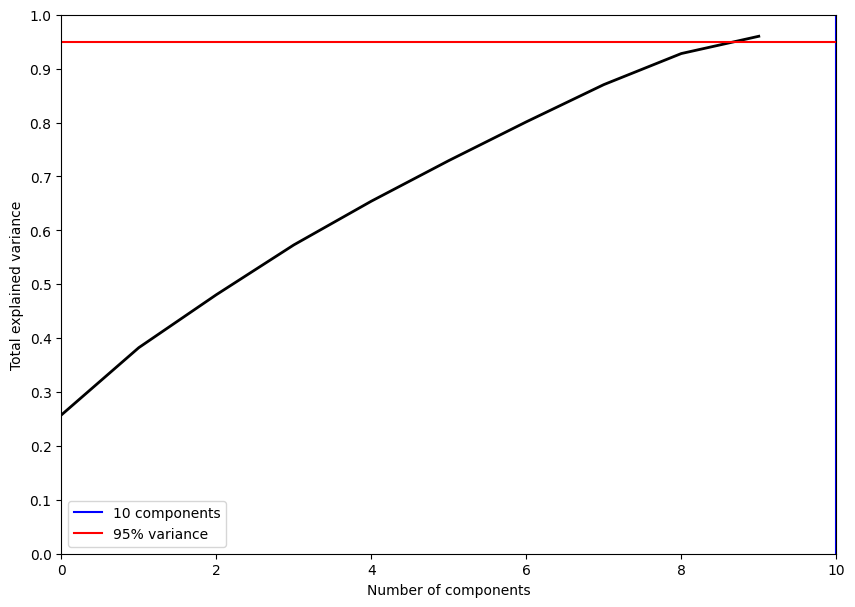

In [48]:
# Step 4: Plotting
plt.figure(figsize=(10, 7))
plt.plot(cumulative_variance, color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, len(cumulative_variance))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(pca.n_components_, c='b', label=f'{pca.n_components_} components')
plt.axhline(0.95, c='r', label='95% variance')
plt.legend()
plt.show()

In [50]:
# Step 4: Create a DataFrame for Principal Component Loadings
# Each column shows how much a feature contributes to a principal component
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'Principal Component {i+1}' for i in range(pca.n_components_)],
    index=selected_features
)

# Display the loadings DataFrame
print("Feature Contributions to Principal Components:")
print(loadings)

Feature Contributions to Principal Components:
                  Principal Component 1  Principal Component 2  \
acousticness                  -0.440481               0.215932   
danceability                   0.306516               0.508978   
energy                         0.490527              -0.263143   
instrumentalness              -0.313767              -0.123150   
liveness                       0.042022              -0.115393   
loudness                       0.473749              -0.203820   
speechiness                    0.025323               0.430630   
valence                        0.325461               0.390311   
tempo                          0.193530              -0.134148   
duration_ms                   -0.039905              -0.444167   
key                            0.026775               0.044407   
mode                          -0.020607              -0.003063   

                  Principal Component 3  Principal Component 4  \
acousticness                

In [51]:
# Step 5: Create and Display DataFrame
components_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance': explained_variance,
    'Cumulative Variance': cumulative_variance
})

# Print the DataFrame
print("\nExplained Variance for Principal Components:")
print(components_df)


Explained Variance for Principal Components:
  Principal Component  Explained Variance  Cumulative Variance
0                 PC1            0.257310             0.257310
1                 PC2            0.124983             0.382293
2                 PC3            0.098189             0.480482
3                 PC4            0.092407             0.572890
4                 PC5            0.081113             0.654003
5                 PC6            0.075345             0.729347
6                 PC7            0.071887             0.801234
7                 PC8            0.069076             0.870311
8                 PC9            0.057652             0.927962
9                PC10            0.032063             0.960026


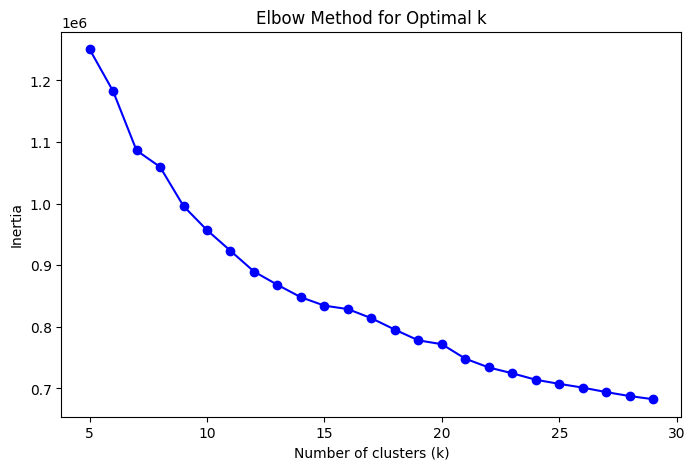

In [14]:
# Step 4: Determine Optimal k (Elbow Method)
inertias = []
k_values = range(5, 30)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_features)
    inertias.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [38]:
# Step 5: Apply k-Means with Optimal k
optimal_k = 8
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_features)

# Assign clusters to the original DataFrame
songs_df['cluster'] = kmeans.labels_

In [39]:
# Function to retrieve song data from Spotify API
def find_song_from_spotify(name, year):
    song_data = defaultdict()
    results = sp.search(q=f'track:{name} year:{year}', limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]

    # Basic metadata
    song_data['name'] = results['name']
    song_data['artists'] = ', '.join([artist['name'] for artist in results['artists']])
    song_data['year'] = year
    song_data['duration_ms'] = results['duration_ms']
    song_data['explicit'] = int(results['explicit'])

    # Audio features
    for key, value in audio_features.items():
        if key in selected_features:
            song_data[key] = value

    return song_data

In [40]:
def recommend_songs_kmeans_with_api(song_names, songs_df, pca_model, scaler, kmeans_model, n_recommendations=10):
    # Ensure 'cluster' column exists
    if 'cluster' not in songs_df.columns:
        raise KeyError("'cluster' column not found in songs_df. Ensure k-means clustering is performed.")

    clusters = []
    input_song_names = []
    new_songs = []  # Store newly added songs for dynamic clustering

    for song_name, year in song_names:
        matched_songs = songs_df[songs_df['name'].str.lower() == song_name.lower()]
        if matched_songs.empty:
            print(f"Song '{song_name}' not found in the dataset. Fetching from Spotify...")
            # Attempt to fetch song from Spotify API
            spotify_song_data = find_song_from_spotify(song_name, year)  # Replace 2022 with dynamic input
            if spotify_song_data:
                new_songs.append(spotify_song_data)
                print(f"Added '{spotify_song_data['name']}' from Spotify.")
            else:
                print(f"Could not find '{song_name}' on Spotify.")
            continue

        input_song_names.append(song_name.lower())
        song_clusters = matched_songs['cluster'].unique()
        clusters.extend(song_clusters)

    # Dynamically cluster new songs (if any)
    if new_songs:
        new_songs_df = pd.DataFrame(new_songs)
        scaled_new_features = scaler.transform(new_songs_df[selected_features])
        pca_new_features = pca_model.transform(scaled_new_features)
        new_clusters = kmeans_model.predict(pca_new_features)
        new_songs_df['cluster'] = new_clusters
        songs_df = pd.concat([songs_df, new_songs_df], ignore_index=True)
        clusters.extend(new_clusters)

    if not clusters:
        print("No matching songs found in the dataset or Spotify.")
        return []

    # Unique clusters
    clusters = list(set(clusters))

    # Songs in the same cluster(s)
    recommended_songs = songs_df[songs_df['cluster'].isin(clusters)]

    # Exclude input songs
    recommended_songs = recommended_songs[~recommended_songs['name'].str.lower().isin(input_song_names)]

    # Randomly select recommendations
    recommended_songs = recommended_songs.sample(n=n_recommendations, random_state=42)
    return recommended_songs[['name', 'artists', 'cluster']]


In [41]:
# Test input
input_songs = [{'name': 'Come As You Are', 'year':1991},
                {'name': 'Smells Like Teen Spirit', 'year': 1991},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Stay Away', 'year': 1993}]

# Get recommendations
recommendations = recommend_songs_kmeans_with_api(
    input_songs,
    songs_df,
    pca_model=pca,
    scaler=scaler,
    kmeans_model=kmeans,
    n_recommendations=10
)

# Display recommendations
print(recommendations)

                          name                                    artists  \
149854        Living Testimony             ['Doug Williams', 'Joe Ligon']   
12661                    Conga  ['Gloria Estefan', 'Miami Sound Machine']   
18269        How Country Feels                           ['Randy Houser']   
90776            Volví a Nacer                           ['Carlos Vives']   
56847                   Casper                                ['Takeoff']   
34437            Brand New Key                                ['Melanie']   
153866  Taking Pictures Of You                              ['The Kooks']   
52556              Nour El Ein                               ['Amr Diab']   
63534       She Don't Love You                             ['Mary Wells']   
65091        I Gotta Get Drunk                          ['Willie Nelson']   

        cluster  
149854        1  
12661         1  
18269         1  
90776         1  
56847         1  
34437         1  
153866        1  
52556   

## Weighted Genre

In [20]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from scipy.spatial.distance import cdist
from collections import defaultdict

In [21]:
# Define feature columns
number_cols = ['acousticness', 'danceability', 'energy', 'instrumentalness',
               'liveness', 'loudness', 'speechiness', 'valence', 'tempo',
               'duration_ms', 'key', 'mode']

In [22]:
def classify_songs_by_genre(songs_df, genre_df, feature_columns):
    """
    Assign each song in the songs_df to the closest genre based on shared features in genre_df.
    """
    # Ensure all features are numeric and explicitly cast to float64
    songs_df[feature_columns] = songs_df[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(songs_df[feature_columns].mean())
    genre_df[feature_columns] = genre_df[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(genre_df[feature_columns].mean())

    # Extract genre features and explicitly cast to float64
    genre_features = genre_df[feature_columns].values.astype(np.float64)
    classified_genres = []

    for _, song in songs_df.iterrows():
        # Extract features for the current song and explicitly cast to float64
        song_features = song[feature_columns].values.reshape(1, -1).astype(np.float64)

        # Compute distances between the song and all genres
        distances = cdist(song_features, genre_features, metric='euclidean')

        # Assign the closest genre
        closest_genre_index = distances.argmin()
        closest_genre = genre_df.iloc[closest_genre_index]['genres']
        classified_genres.append(closest_genre)

    # Add the classified genres to the songs DataFrame
    songs_df['classified_genre'] = classified_genres
    return songs_df

In [23]:
# Classify songs into different genres
songs_df = classify_songs_by_genre(songs_data, genre_data, number_cols)

In [24]:
songs_df.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,classified_genre
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,hungarian folk
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,black punk
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913000,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339,modern big band
3,0.1650,1921,0.967,['Frank Parker'],0.275,210000,0.309,0,3ftBPsC5vPBKxYSee08FDH,0.000028,5,0.381,-9.316,1,Danny Boy,3,1921,0.0354,100.109,italian mezzo-soprano
4,0.2530,1921,0.957,['Phil Regan'],0.418,166693,0.193,0,4d6HGyGT8e121BsdKmw9v6,0.000002,3,0.229,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,vintage swedish pop


In [25]:
def add_genre_vector(songs_df):
    """
    Add one-hot encoded genre vectors to the songs dataset.
    """
    # One-hot encode the genres
    genre_encoder = OneHotEncoder(sparse_output=False)
    genre_encoded = genre_encoder.fit_transform(songs_df[['classified_genre']])
    songs_df['genre_vector'] = list(genre_encoded)
    return songs_df, genre_encoder

# Add genre vectors
songs_df, genre_encoder = add_genre_vector(songs_df)

In [26]:
# Define feature weights
feature_weights = {
    'valence': 1.0,
    'year': 0.5,
    'acousticness': 1.0,
    'danceability': 1.5,
    'duration_ms': 0.5,
    'energy': 2.0,
    'explicit': 0.1,
    'instrumentalness': 1.0,
    'key': 0.2,
    'liveness': 1.0,
    'loudness': 1.5,
    'mode': 0.5,
    'popularity': 1.0,
    'speechiness': 1.0,
    'tempo': 1.5,
    'genre': 1.0  # Weight for genre vector
}

def get_song_vector_with_weights(song, spotify_data, feature_weights):
    """
    Retrieve the combined song vector (features + genre) with applied weights.
    If the song is not found in the dataset, fetch it from Spotify API.
    """
    try:
        # Try to retrieve the song from the dataset
        song_data = spotify_data[(spotify_data['name'].str.lower() == song['name'].lower()) &
                                 (spotify_data['year'] == song['year'])].iloc[0]
    except IndexError:
        # Song not found in dataset, fetch from Spotify API
        print(f"Fetching '{song['name']}' from Spotify API...")
        song_data = find_song_from_spotify(song['name'], song['year'])
        if song_data is None:
            print(f"Could not find '{song['name']}' on Spotify.")
            return None

    # Combine numerical features and genre vector
    feature_vector = song_data[number_cols].values if isinstance(song_data, pd.Series) else song_data[number_cols].to_numpy()
    genre_vector = np.zeros(len(spotify_data['genre_vector'].iloc[0]))  # Default no genre vector if fetched from API
    if 'genre_vector' in song_data and isinstance(song_data['genre_vector'], np.ndarray):
        genre_vector = np.array(song_data['genre_vector'])

    combined_vector = np.concatenate([feature_vector, genre_vector])

    # Apply weights to the vector
    weighted_features = np.array([feature_vector[i] * feature_weights[col] for i, col in enumerate(number_cols)])
    weighted_genre = genre_vector * feature_weights['genre']
    return np.concatenate([weighted_features, weighted_genre])

In [31]:
def get_weighted_average_vector(song_list, spotify_data, feature_weights):
    """
    Compute a weighted average vector for the input songs, including genre influence.
    """
    vectors = []
    weights = []

    for song in song_list:
        try:
            # Try to retrieve the combined song vector
            song_vector = get_song_vector_with_weights(song, spotify_data, feature_weights)
            if song_vector is not None:
                vectors.append(song_vector)
                weights.append(1.0)  # Adjust weights dynamically if needed
        except Exception as e:
            print(f"Warning: Could not process '{song['name']}' due to {e}. Skipping...")
            continue

    if len(vectors) == 0:
        raise ValueError("No valid song vectors found.")

    vectors = np.vstack(vectors)
    weights = np.array(weights).reshape(-1, 1)
    return np.average(vectors, axis=0, weights=weights.flatten())

In [32]:
def recommend_songs_with_genre(song_list, spotify_data, n_songs=10):
    """
    Recommend songs based on weighted vectors and genre influence.
    """
    metadata_cols = ['name', 'year', 'artists', 'classified_genre']

    # Step 1: Compute the weighted average vector for the input songs
    song_center = get_weighted_average_vector(song_list, spotify_data, feature_weights)

    # Step 2: Scale only the numerical features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(spotify_data[number_cols])  # Scale numerical features
    scaled_song_center = scaler.transform([song_center[:len(number_cols)]])  # Scale only the numerical part of the input vector

    # Step 3: Combine scaled numerical features with genre vectors
    genre_vectors = np.array(list(spotify_data['genre_vector']))
    combined_data = np.hstack([scaled_data, genre_vectors])  # Combine scaled numerical and genre vectors
    combined_song_center = np.hstack([scaled_song_center[0], song_center[len(number_cols):]])  # Combine input features

    # Step 4: Compute distances and find nearest songs
    distances = cdist([combined_song_center], combined_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])

    # Exclude input songs from recommendations
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['name'].isin([song['name'] for song in song_list])]
    return rec_songs[metadata_cols].to_dict(orient='records')


In [33]:
# Test input songs
input_songs = [{'name': 'Come As You Are', 'year':1991},
                {'name': 'Smells Like Teen Spirit', 'year': 1991},
                {'name': 'Lithium', 'year': 1992},
                {'name': 'All Apologies', 'year': 1993},
                {'name': 'Stay Away', 'year': 1993}
               ]

# Get recommendations
recommendations = recommend_songs_with_genre(input_songs, songs_df, n_songs=10)

# Convert recommendations to a DataFrame
recommendations_df = pd.DataFrame(recommendations)

# Display the DataFrame
print(recommendations_df)

ERROR:spotipy.client:HTTP Error for GET to https://api.spotify.com/v1/audio-features/?ids=5Aa0IaY12vHUtB4KmdsUyn with Params: {} returned 403 due to None


Fetching 'Stay Away' from Spotify API...
 None, reason: None. Skipping...


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


                                  name  year                        artists  \
0         We Got The Beat - Single Mix  1994                ["The Go-Go's"]   
1       All I Ever Wanted - Radio Edit  2008                 ['Basshunter']   
2                         Doctor Jones  1997                       ['Aqua']   
3                         Nasty Habits  1981               ['Oingo Boingo']   
4                      We Got The Beat  1981                ["The Go-Go's"]   
5  Dam Dadi Doo - Nightcore Single Mix  2002  ['Fantasy Project feat. NDA']   
6                    It Doesn't Matter  1986                       ['Ratt']   
7             If You Could Be Anywhere  2010                 ['Tom Felton']   
8                                Stain  1992                    ['Nirvana']   
9                  Miracle - Radio Mix  2006                    ['Cascada']   

         classified_genre  
0     classic finnish pop  
1         vintage chanson  
2          banda caliente  
3              rap